# 実数値遺伝的アルゴリズムのデモプログラム

中身に関しては下記で解説しています。  
https://yuyumoyuyu.com/2021/04/04/realcodedgeneticalgorithm/  
  
参考文献は以下です。  
実数型GAに於ける交叉法の改良: https://www.sist.ac.jp/~kanakubo/research/evolutionary_computing/lbx_spx.html  
単峰性正規分布交叉UNDXを用いた実数値GAによる関数最適化: https://www.jstage.jst.go.jp/article/jjsai/14/6/14_1146/_article/-char/ja/  
実数値GAのための正規分布交叉の多数の親を用いた拡張法の提案: https://www.jstage.jst.go.jp/article/sicetr1965/36/10/36_10_875/_article/-char/ja/  
実数値GAのフロンティア: https://www.jstage.jst.go.jp/article/tjsai/24/1/24_1_147/_article/-char/ja/  
実数値GAにおけるシンプレクス交叉の提案: https://www.jstage.jst.go.jp/article/tjsai/16/1/16_1_147/_article/-char/ja/

In [1]:
import math
import random
import time
import bisect

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# User-defined function
from benchmark_function import BenchmarkFunction as BF

In [2]:
# ベンチマーク関数の呼び出し
bf = BF()

# ベンチマーク関数の選択
benchmark_function = 'ackley'

In [3]:
# 遺伝的アルゴリズムのクラス定義
class GeneticAlgorithm:
    def __init__(self, weights):
        # 重みが正なら最大化，負なら最小化
        self.weights = np.array(weights)
        
    def individual(self, dimension): # 個体の生成
        v_list = list( (np.random.rand(dimension)*2-1)*bf.search_area()[benchmark_function][1] )
        return v_list
        
    def population(self, N_pop, dimension): # 集団の生成
        self.dimension = dimension
        population = [self.individual(dimension) for i in range(N_pop)]
        return np.array(population)
    
    def evaluate_ind(self, individual): # 個体評価
        # 個体の評価関数を変更したいなら，ここを弄る！！！
        return list( eval('bf.'+benchmark_function)(np.array(individual).reshape(1,-1)) )

    def evaluate(self, population): # 集団評価
        N_pop = population.shape[0]
        fitnesses = [np.array(self.evaluate_ind(population[i])) for i in range(N_pop)]
        return np.array(fitnesses)

In [4]:
# 世代交代モデルの定義
class GeneticAlgorithm(GeneticAlgorithm):
    # ルーレット選択
    def roulette_wheel_selection(self, population): #MGG用に1個体の選択を想定して作成
        fitnesses = self.evaluate(np.array(population))
        fitnesses_sum = (fitnesses * self.weights).flatten()
        f_max = fitnesses_sum.max()
        f_min = fitnesses_sum.min()
        
        fmax = 3
        fmin = 1
        a = (fmax-fmin)/(f_max-f_min+1.0e-8)
        b = fmin-a*f_min
        
        fitness_scaled = a*fitnesses_sum+b
        fitnesses_scaled_sum = fitness_scaled.sum()
        fitnesses_scaled_sumlist = np.dot(fitness_scaled,
                                          np.triu(np.ones([fitness_scaled.shape[0],
                                                           fitness_scaled.shape[0]]))
                                         )
        
        random_number = random.random()*fitnesses_scaled_sum
        selected_number = bisect.bisect_right(fitnesses_scaled_sumlist, 
                                              random_number)
        selected_individual = population.pop(selected_number)
        fitness_selected = fitnesses[selected_number]
        
        return selected_individual, fitness_selected
    
    # 最良選択
    def best_selection(self, population, N_selection):
        fitnesses = self.evaluate(population)
        fitnesses_sum = (fitnesses * self.weights).flatten()
        fitnesses_best = np.sort(fitnesses_sum)[-N_selection:]
        index = np.argsort(fitnesses_sum)[-N_selection:]
        pop_selected = [population[i] for i in index]
        pop_unselected = [population[i] for i in range(len(population)) if i not in index]
        
        return pop_selected, fitnesses[index], pop_unselected
    
    # 世代交代モデルMGG
    def minimal_generation_gap(self, offspring, N_parents, N_children, model):
        parents = offspring[random.sample(list(range(offspring.shape[0])), N_parents)]
        children = model(parents, N_children)
        
        indices = random.sample(list(range(parents.shape[0])), 2)
        parents_selected = parents[indices]
        children = np.vstack((children,parents_selected))
        
        children_selected, fitnesses_selected, children_unselected = \
            self.best_selection(children, 1)
        children_selected2, fitnesses_selected2 = \
            self.roulette_wheel_selection(children_unselected)
        offspring_updated = np.stack([children_selected[0], children_selected2])
        fitnesses_updated = np.array([fitnesses_selected, fitnesses_selected2]).flatten()
        
        return offspring, indices, offspring_updated, fitnesses_updated
    
    # 世代交代モデルJGG
    def just_generation_gap(self, offspring, N_parents, N_children, model):
        if N_children < N_parents: raise Exception("N_children should be larger than N_parents.")
        
        indices = random.sample(list(range(offspring.shape[0])), N_parents)
        parents = offspring[indices]
        children = model(parents, N_children)
        children_selected, fitnesses_selected, _ = self.best_selection(children, N_parents)
        
        return offspring, indices, children_selected, fitnesses_selected
    
    # 世代交代モデルの選択
    def choose_model(self, generation_alternation_model_number):
        if generation_alternation_model_number == 0:
            generation_alternation_model = self.minimal_generation_gap
        elif generation_alternation_model_number == 1:
            generation_alternation_model = self.just_generation_gap
            
        return generation_alternation_model

In [5]:
# 実数値交叉の定義
class GeneticAlgorithm(GeneticAlgorithm):
    def blend_crossover_alpha(self, parents, N_children):
        '''
        BLX
        parents2個体を選択して子個体を生成。
        alphaは0.5以下（0.3前後）がよく用いられる（らしい）
        '''
        alpha = 0.3
        parents = np.array(parents)

        difference = np.abs( parents[0]-parents[1] )
        children_upr = ( parents[0]+parents[1]+( 2*alpha+1 )*difference )/2
        children_lwr = ( parents[0]+parents[1]-( 2*alpha+1 )*difference )/2
        children = np.random.rand(N_children, parents.shape[1]) * (children_upr-children_lwr) + children_lwr
        return children

    def unimodal_normal_distribution_crossover(self, parents, N_children):
        '''
        UNDX
        xi_sigma = 1/dim**0.5
        parents3個体を選択して子個体を生成。
        '''
        parents = np.array(parents)
        dim = parents.shape[1]

        midpoint12_vector = ( parents[0]+parents[1] )/2

        difference12_vector = parents[1]-parents[0]
        difference12_magnitude = np.linalg.norm( difference12_vector,ord=2 )
        if difference12_magnitude == 0:
            e12_vector = difference12_vector
        else:
            e12_vector = difference12_vector/difference12_magnitude

        difference13_vector = parents[2]-parents[0]
        difference12_3_vector = difference13_vector - \
                                np.dot( difference13_vector,e12_vector )*e12_vector
        difference12_3_magnitude = np.linalg.norm( difference12_3_vector,ord=2 )    

        linear_independence_vectors = np.identity(dim)  #線形独立なベクトルとして単位行列
        if np.count_nonzero(e12_vector) != 0:
            index = np.nonzero(e12_vector)[0][0]
            linear_independence_vectors[index] = e12_vector

        Q, _ = np.linalg.qr(linear_independence_vectors.T)
        Q = np.delete(Q.T, index, 0)
        eta = np.random.normal(0, 0.35/(dim**0.5), (N_children, dim-1))

        xi = np.random.normal(0, 0.5, (1, N_children)).reshape(-1,1)

        children = midpoint12_vector + np.dot(xi, difference12_vector.reshape(1,-1)) \
                + difference12_3_magnitude*np.dot(eta, Q)

        return children

    def unimodal_normal_distribution_crossover_m(self, parents, N_children):
        '''
        UNDX-m
        parentsをm=dim+1個体選択して子個体を生成。
        xi_sigma = 1/dim**0.5
        '''        
        parents = np.array(parents)
        dim = parents.shape[1] # 親の次元
        N_parents = parents.shape[0] # 親の個体数(=n+1)

        midpoint_vector = parents.sum(axis=0)/N_parents

        difference_vector = parents-midpoint_vector
        xi = np.random.normal(loc=0, 
                              scale=1/dim**0.5, 
                              size=(N_children,dim))
        children = midpoint_vector + np.dot(xi,difference_vector[:-1])

        return children

    def simplex_crossover(self, parents, N_children):
        '''
        SPX
        parentsをdim+1個体選択して子個体を生成。
        epsilonの推奨値はdimを親個体の次元としてsqrt(dim+2)
        '''
        parents = np.array(parents)
        N_parents = parents.shape[0]
        parents_avg = parents.sum(axis=0)/N_parents

        dim = parents.shape[1]
        epsilon = (dim+2)**0.5


        xi = parents_avg+epsilon*(parents-parents_avg)
        ri = np.power(np.random.rand(N_parents, N_children),
                      np.tile(1/np.arange(1,N_parents+1,1),(N_children,1)).T)
        ri = ri.reshape(N_parents,N_children,1)
        Ci = np.zeros([N_children, dim])
        for i in range(1,N_parents):
            Ci = ri[i] * (xi[i-1]-xi[i]+Ci)

        children = xi[-1]+Ci

        return children

    def real_coded_ensemble_crossover_star(self, parents, N_children):
        '''
        REX-star
        parentsをdim+1個体選択して子個体を生成。
        t = 6で仮設定
        '''
        parents = np.array(parents)
        N_parents = parents.shape[0]
        dim = parents.shape[1]
        
        midpoint_vector = parents.sum(axis=0)/N_parents
        difference_vector = parents-midpoint_vector
        parents_mirror = parents - 2*difference_vector
        
        parents_w_mirror = np.vstack((parents, parents_mirror))
        fitnesses = (self.evaluate(parents_w_mirror)*self.weights).flatten()
        
        parents_high_fitness = parents_w_mirror[fitnesses.argsort()][N_parents:]
        midpoint_vector_high_fitness = parents_high_fitness.sum(axis=0)/N_parents
        direction = midpoint_vector_high_fitness - midpoint_vector
        
        t = 6
        xi_t = np.random.rand(N_children,dim)*t
        xi = (np.random.rand(N_children,N_parents)*2-1)*(3/(N_parents))**0.5
        children = midpoint_vector + xi_t*direction \
                   + np.dot(xi,difference_vector)
        return children

    def choose_crossover_model(self, crossover_model_number):
        if crossover_model_number == 0:
            crossover_model = self.blend_crossover_alpha
            number_of_parents = 2
        elif crossover_model_number == 1:
            crossover_model = self.unimodal_normal_distribution_crossover
            number_of_parents = 3
        elif crossover_model_number == 2:
            crossover_model = self.unimodal_normal_distribution_crossover_m
            number_of_parents = self.dimension+1
        elif crossover_model_number == 3:
            crossover_model = self.simplex_crossover
            number_of_parents = self.dimension+1
        elif crossover_model_number == 4:
            crossover_model = self.real_coded_ensemble_crossover_star
            number_of_parents = self.dimension+1
        
        return crossover_model, number_of_parents

In [6]:
# 重みの設定
# 正なら最大化，負なら最小化
# 多目的最適化なら配列を指定（評価関数も変える必要あり）
weights = -1.0
GA = GeneticAlgorithm(weights)

In [7]:
random.seed(1)

dimension = 20              # 次元
N_generation = 300          # 繰り返し世代数
N_population = 7*dimension  # 集団内の個体数 
N_children = 6*dimension    # 生成する子個体の数 

In [8]:
# 手法の選択
generation_alternation_model_number = 1 # 0: MGG, 1: JGG
crossover_model_number = 4 # 0: BLX, 1: UNDX, 2: UNDX-m, 3: SPX, 4: REXstar

In [9]:
#GAスタート
ut = time.time()
print("Start\n")

population = GA.population(N_population, dimension)

generation_alternation_model = GA.choose_model(generation_alternation_model_number)
crossover_model, number_of_parents = GA.choose_crossover_model(crossover_model_number)

fitnesses = GA.evaluate(population)

fits_min_list = []
fits_max_list = []
fits_avg_list = []
fits_std_list = []
fitnesses_list = [fitnesses.copy()]
check = 0
# 進化ループ開始
for g in range(1,N_generation+1):

    print("-- Generation %i --" % g)
    print("  Elapsed time: {:.3f} sec".format(time.time()-ut))
    offspring, indices, offspring_updated, fitnesses_updated = \
        generation_alternation_model(population, number_of_parents, N_children, crossover_model)

    for i, j in enumerate(indices):
        offspring[j] = list(offspring_updated[i])
        fitnesses[j] = fitnesses_updated[i]
    
    fitnesses_list.append(fitnesses.copy())
    
    population[:] = offspring

    fits = np.dot(fitnesses, np.array(weights))
#     index_min = fits.argmin()
#     index_max = fits.argmax()
    fits_min = fitnesses.min()
    fits_max = fitnesses.max()
    fits_avg = fitnesses.mean()
    fits_std = fitnesses.std()
    
    fits_min_list.append(fits_min)
    fits_max_list.append(fits_max)
    fits_avg_list.append(fits_avg)
    fits_std_list.append(fits_std)
    
    print("  Min: {:.3f}".format(fits_min))
    print("  Max: {:.3f}".format(fits_max))
    print("  Avg: {:.3f}".format(fits_avg))
    print("  Std: {:.3f}".format(fits_std))
    
# 最良個体の抽出
best_individual, best_fitness, other = GA.best_selection(population, 3)

print("Parameters of the top 3 individual:\n{}".format(np.array(best_individual)))
print("Value of the top 3 individual:\n{}".format(best_fitness))

print("Elapsed time: {:.3f} sec".format(time.time()-ut))

Start

-- Generation 1 --
  Elapsed time: 0.009 sec
  Min: 19.719
  Max: 21.641
  Avg: 21.139
  Std: 0.287
-- Generation 2 --
  Elapsed time: 0.023 sec
  Min: 19.698
  Max: 21.641
  Avg: 21.057
  Std: 0.350
-- Generation 3 --
  Elapsed time: 0.031 sec
  Min: 19.201
  Max: 21.607
  Avg: 20.950
  Std: 0.457
-- Generation 4 --
  Elapsed time: 0.038 sec
  Min: 18.201
  Max: 21.607
  Avg: 20.814
  Std: 0.585
-- Generation 5 --
  Elapsed time: 0.046 sec
  Min: 18.201
  Max: 21.584
  Avg: 20.712
  Std: 0.618
-- Generation 6 --
  Elapsed time: 0.054 sec
  Min: 18.882
  Max: 21.584
  Avg: 20.629
  Std: 0.583
-- Generation 7 --
  Elapsed time: 0.061 sec
  Min: 18.538
  Max: 21.584
  Avg: 20.517
  Std: 0.597
-- Generation 8 --
  Elapsed time: 0.069 sec
  Min: 18.341
  Max: 21.584
  Avg: 20.386
  Std: 0.635
-- Generation 9 --
  Elapsed time: 0.078 sec
  Min: 18.341
  Max: 21.584
  Avg: 20.279
  Std: 0.624
-- Generation 10 --
  Elapsed time: 0.078 sec
  Min: 17.209
  Max: 21.584
  Avg: 20.151
  Std

  Min: 2.611
  Max: 6.487
  Avg: 4.073
  Std: 0.631
-- Generation 99 --
  Elapsed time: 0.785 sec
  Min: 2.946
  Max: 6.487
  Avg: 4.028
  Std: 0.653
-- Generation 100 --
  Elapsed time: 0.797 sec
  Min: 2.886
  Max: 6.487
  Avg: 3.948
  Std: 0.652
-- Generation 101 --
  Elapsed time: 0.804 sec
  Min: 2.886
  Max: 6.487
  Avg: 3.870
  Std: 0.648
-- Generation 102 --
  Elapsed time: 0.812 sec
  Min: 2.886
  Max: 6.405
  Avg: 3.806
  Std: 0.593
-- Generation 103 --
  Elapsed time: 0.821 sec
  Min: 2.886
  Max: 6.405
  Avg: 3.737
  Std: 0.608
-- Generation 104 --
  Elapsed time: 0.828 sec
  Min: 2.844
  Max: 6.405
  Avg: 3.658
  Std: 0.617
-- Generation 105 --
  Elapsed time: 0.836 sec
  Min: 2.663
  Max: 5.646
  Avg: 3.600
  Std: 0.526
-- Generation 106 --
  Elapsed time: 0.843 sec
  Min: 2.663
  Max: 5.646
  Avg: 3.548
  Std: 0.521
-- Generation 107 --
  Elapsed time: 0.846 sec
  Min: 2.446
  Max: 5.646
  Avg: 3.481
  Std: 0.512
-- Generation 108 --
  Elapsed time: 0.846 sec
  Min: 2.54

  Min: 0.047
  Max: 0.460
  Avg: 0.125
  Std: 0.050
-- Generation 195 --
  Elapsed time: 1.552 sec
  Min: 0.047
  Max: 0.399
  Avg: 0.118
  Std: 0.042
-- Generation 196 --
  Elapsed time: 1.560 sec
  Min: 0.047
  Max: 0.399
  Avg: 0.113
  Std: 0.041
-- Generation 197 --
  Elapsed time: 1.569 sec
  Min: 0.047
  Max: 0.399
  Avg: 0.108
  Std: 0.043
-- Generation 198 --
  Elapsed time: 1.576 sec
  Min: 0.047
  Max: 0.399
  Avg: 0.105
  Std: 0.043
-- Generation 199 --
  Elapsed time: 1.584 sec
  Min: 0.047
  Max: 0.399
  Avg: 0.100
  Std: 0.043
-- Generation 200 --
  Elapsed time: 1.593 sec
  Min: 0.047
  Max: 0.399
  Avg: 0.095
  Std: 0.044
-- Generation 201 --
  Elapsed time: 1.595 sec
  Min: 0.051
  Max: 0.256
  Avg: 0.091
  Std: 0.028
-- Generation 202 --
  Elapsed time: 1.595 sec
  Min: 0.046
  Max: 0.256
  Avg: 0.086
  Std: 0.030
-- Generation 203 --
  Elapsed time: 1.611 sec
  Min: 0.046
  Max: 0.256
  Avg: 0.083
  Std: 0.030
-- Generation 204 --
  Elapsed time: 1.611 sec
  Min: 0.0

  Min: 0.001
  Max: 0.006
  Avg: 0.003
  Std: 0.001
-- Generation 291 --
  Elapsed time: 2.312 sec
  Min: 0.001
  Max: 0.006
  Avg: 0.003
  Std: 0.001
-- Generation 292 --
  Elapsed time: 2.323 sec
  Min: 0.001
  Max: 0.006
  Avg: 0.003
  Std: 0.001
-- Generation 293 --
  Elapsed time: 2.331 sec
  Min: 0.001
  Max: 0.006
  Avg: 0.003
  Std: 0.001
-- Generation 294 --
  Elapsed time: 2.340 sec
  Min: 0.001
  Max: 0.005
  Avg: 0.002
  Std: 0.001
-- Generation 295 --
  Elapsed time: 2.347 sec
  Min: 0.001
  Max: 0.005
  Avg: 0.002
  Std: 0.001
-- Generation 296 --
  Elapsed time: 2.355 sec
  Min: 0.001
  Max: 0.005
  Avg: 0.002
  Std: 0.001
-- Generation 297 --
  Elapsed time: 2.363 sec
  Min: 0.001
  Max: 0.005
  Avg: 0.002
  Std: 0.001
-- Generation 298 --
  Elapsed time: 2.371 sec
  Min: 0.001
  Max: 0.005
  Avg: 0.002
  Std: 0.001
-- Generation 299 --
  Elapsed time: 2.379 sec
  Min: 0.001
  Max: 0.005
  Avg: 0.002
  Std: 0.001
-- Generation 300 --
  Elapsed time: 2.388 sec
  Min: 0.0

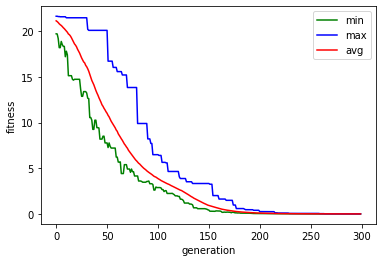

In [10]:
plt.plot(fits_min_list, '-', c='g', label='min')
plt.plot(fits_max_list, '-', c='b', label='max')
plt.plot(fits_avg_list, '-', c='r', label='avg')

plt.xlabel('generation')
plt.ylabel('fitness')

plt.legend()